In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler

import argparse
import random
import os
import math

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

In [5]:
seed_torch(24)

In [6]:
class MLP(nn.Module):
    """Deep Neural Network"""

    def __init__(self, L, M, dim_hidden, hidden_layers, dim_out,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        
        dim_in = M * 2 + 2
        
        model = nn.Sequential()
        
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
            
        self.model = model
        
        self.L = L
        self.M = M
        
        if init_name is not None:
            self.init_weight(init_name)

            
        self.k = nn.Parameter(torch.arange(1, self.M+1), requires_grad=False)
                    
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
#         for layer, param in enumerate(self.parameters()):
#             if layer % 2 == 1:
#                 nn.init.constant_(param, 0.0)
#             else:
#                 nn_init(param)
                
    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        out = torch.cat([t, torch.ones_like(t), 
                            torch.cos(self.k * w * x), torch.sin(self.k * w * x)], dim = 1) 
        
        return out    
            
    def forward(self, H):
        t = H[:, 0:1]
        x = H[:, 1:2]
        
        H = self.input_encoding(t, x)
        H = self.model(H)
        
        return H
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params
    
    def print(self):
        print(self.bias)

In [7]:
model = MLP(L=2.0, M=10, dim_hidden=128, hidden_layers=4, dim_out=1)

KDV方程：
$$
\left\{\begin{matrix}
&u_{t}+ \lambda_1 u u_{x} + \lambda_2 u_{xxx}=0  ,(t,x)\in (0,1)\times (-1,1),  \\
&u(0,x)= cos(\pi x),  \\
&u(t,-1)=u(t,1),t\in [0,1],  \\
&u_x(t,-1)=u_x(t,1),x\in [0,1].
\end{matrix}\right.
$$
$\lambda_1 = 1.000$, $\lambda_2 = 0.0025$.

## Options

In [8]:
import argparse
class Options_KDV(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=12, help='neurons in hidden layers')     # 10 9
        parser.add_argument('--hidden_layers', type=int, default=9, help='number of hidden layers')    # 4  20
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=0.001, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=300000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=2500, help='epochs for LBFGS optimizer')
        parser.add_argument('--newton_iter', type=int, default=100, help='newton_iter for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=50000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.9, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--tol', type=float, default=100, help='the annealing scheme')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.load_model = False
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        # arg.cuda = False
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(arg.cuda)
        print(arg.device)
        return arg

args = Options_KDV().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

True
cuda
9


In [9]:
model.to(device)
args.model=model

## 数据集生成

In [10]:
class Trainset_KDV():
    '''
    训练点:时间剖分 100 段， 空间上分成25段，每段上取4个高斯点
    '''
    def __init__(self, *args):
        self.args = args
        self.shape = (self.args[0], self.args[1])
        
    def __call__(self):
        return self.data()
    
    def data(self):
        # 为了生成高斯积分点，n_x一定要是4的倍数
        gp = np.array([0.8611363116,-0.8611363116,0.3399810436,-0.3399810436])
        gc = np.array([0.3478548451,0.3478548451,0.6521451549,0.6521451549])
        n_t = self.args[0]
        n_x = self.args[1]
        n_ics = self.args[2]
        
        # 生成初值训练点
        t = np.linspace(0, 1, n_t)
        x = np.linspace(-1, 1, n_x)
        x, t = np.meshgrid(x, t)
        tx = np.hstack((t.reshape(-1,1), x.reshape(-1,1)))

        t_ics = np.zeros(n_ics)
        x_ics = np.linspace(-1, 1, n_ics)
        tx_ics = np.hstack([t_ics.reshape(-1,1),x_ics.reshape(-1,1)])
        
        u_ics = np.cos(math.pi*x_ics)
        u_ics = u_ics.reshape(-1,1)
        M = np.triu(np.ones([n_t, n_t]),k=1).T
        
        # 生成tgx(高斯训练点)
        num_cell = int(n_x/4 + 1)
        l = np.linspace(-1, 1, num_cell)[:, None]
        l = np.hstack([l[:-1], l[1:]])
        c = (l[:, 1] - l[:, 0])/2
        c = c[:, None]
        gp = gp[None, :]
        d = ((l[:, 1] + l[:, 0])/2)
        d = d[:, None]
        n_p = c * gp + d  # n_p是100个高斯积分点
        n_p = n_p.reshape(n_x, 1)
        gcl = c * gc     # gcl是这100个高斯积分点对应的权重  
        gcl = gcl.reshape(n_x, 1)
        t = np.linspace(0, 1, n_t)[:, None]
        x, t = np.meshgrid(n_p, t) #   mesh size (128, 100)
        print(x.shape)
        txg = np.hstack([t.reshape(-1, 1), x.reshape(-1, 1)])
        # 计算一下初始能量
        E2 =  np.cos(math.pi*n_p) ** 2 * gcl
        E2 = np.sum(E2)
        print(E2)
        
        tx = torch.from_numpy(tx).float().to(device)
        txg = torch.from_numpy(txg).float().to(device)
        
        tx_ics = torch.from_numpy(tx_ics).float().to(device)
        u_ics = torch.from_numpy(u_ics).float().to(device)
        M = torch.from_numpy(M).float().to(device)
        
        return tx, tx_ics, u_ics, M, gcl, txg, E2

In [11]:
# 构造一个预测网格
# load the data
data = scipy.io.loadmat('../data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]

In [12]:
print(t_star.shape)
print(x_star.shape)
X_pred = np.hstack([np.ones((len(x_star),1)) * t_star[0 + 1], x_star.reshape(-1,1)])
pred = np.zeros((512, 201))

(201,)
(512,)


In [13]:
# 把初值填在第一列
pred[:, 0] = np.cos(math.pi * x_star)

In [14]:
nt = t_star.shape[0]
nx = 100
n_ics = 100

In [15]:
# tgx是高斯点的数据集， shape :(12800, 2) 第一列代表时间，第二列代表空间 ，前100个点表示t = 0 时刻上的采样点，第101个到200表示t = 1/nt 时刻的采样点， 依次类推
trainset = Trainset_KDV(nt, nx, n_ics)
args.trainset = trainset
tx, tx_ics, u_ics, M, gcl, txg, E2 = trainset()  # E2 是初始时刻的平方积分

(201, 100)
0.9999999999999998


## 训练

In [16]:
class Trainer_Wave(object):
    def __init__(self, args):
        self.model = args.model
        self.lr = args.lr
        self.gamma = args.gamma
        self.trainset = args.trainset
        self.step_size = args.step_size
        self.model_name = self.model.__class__.__name__     
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=self.gamma)
        self.epochs_Adam = args.epochs_Adam
        self.tol = args.tol
        
        # data
        self.tx, self.tx_ics, self.u_ics, self.M,  self.gcl, self.txg, self.E2 = self.trainset()
        self.gcl = torch.from_numpy(self.gcl).float().to(device)
        self.E2 = torch.tensor(self.E2).float().to(device)
        self.nx = nx
        self.nt = nt
        
        # Logger
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_energy_log = []
        self.epoch_log = []
        
        self.x_pred = x_star
        self.t_pred = t_star
        self.pred = pred  # (512, 201)

    def net_r(self, tx):
        tx.requires_grad_(True).to(device)
        u = self.model(tx)
        grad_u = grad(u, tx)[0]
        u_t = grad_u[:,[0]]
        u_x = grad_u[:,[1]]
        u_xx = grad(u_x, tx)[0][:, [1]]
        u_xxx = grad(u_xx, tx)[0][:, [1]]

        residual = u_t  + u * u_x + 0.0025 * u_xxx

        return residual

    def net_u(self, tx):
        u = self.model(tx)  
        return u
    
    def loss_ics(self, X, u_ics):
        u_pred = self.net_u(X)
        loss_ics = torch.mean((u_pred - u_ics)**2)
        return loss_ics
    
    def loss_res(self, X):
        r_pred = self.net_r(X)
        loss_r = torch.mean(r_pred**2)
        return loss_r
    
    def energy_loss(self, X):
        q_pred = self.net_u(X)
        num_t = int(len(X)/self.nx)
        q_pred = q_pred.reshape(num_t, 100)
        if self.gcl.shape != (1, 100):
            self.gcl = self.gcl.reshape(1, 100)
        q_pred = q_pred ** 2 * self.gcl
        q_pred = torch.sum(q_pred, axis=1)
        q_pred = (q_pred - self.E2)
        loss_q = torch.mean(q_pred ** 2)
        return loss_q
        
    def loss(self, X0, u_ics, X1):
        if X0[0, 0] == 0:
            L0 = 100 * self.loss_ics(X0, u_ics)
        else:
            L0 = self.loss_ics(X0, u_ics)
        loss = L0 + self.loss_res(X1)  
        return loss
    
    def predict(self, X):
        X = torch.tensor(X).float().to(device)
        pred_u = self.net_u(X)
        pred_u = pred_u.cpu().detach().numpy()
        return pred_u
    
    def train(self):
        start = time.time()
        for i in range(0, self.nt - 1):
            X_train = self.txg[i*100 : (i + 2)*100]
            X_init = X_train[:100]
            X_next = X_train[-100:]
            for epoch in range(self.epochs_Adam):
                self.optimizer_Adam.zero_grad()
                if i == 0:
                    loss_value = self.loss(self.tx_ics, self.u_ics, X_train)
                else:
                    loss_value = self.loss(X_init, u_ics_pred, X_train)
                if loss_value < 1e-6:
                    print(f'i :{i}' + f' Epoch # {epoch}/{self.epochs_Adam}' + f'loss:{loss_value:.2e}')
                    X_pred = np.hstack([np.ones((len(self.x_pred),1)) * self.t_pred[i + 1], self.x_pred.reshape(-1,1)])
                    U_pred = self.predict(X_pred)
                    self.pred[:, [i+1]] = U_pred
                    break
                else:
                    loss_value.backward()
                    self.optimizer_Adam.step()
                    if (epoch+1) % self.step_size == 0:
                        self.scheduler.step()            
                    if epoch % 1000 == 0:
                        if i == 0:
                            loss_ics_value = self.loss_ics(self.tx_ics, self.u_ics)
                        else:
                            loss_ics_value = self.loss_ics(X_init, u_ics_pred)
                        loss_res_value = self.loss_res(X_train)
                        loss_energy = self.energy_loss(X_train)

                        self.loss_log.append(loss_value.detach().cpu())
                        self.loss_ics_log.append(loss_ics_value.detach().cpu())
                        self.loss_res_log.append(loss_res_value.detach().cpu())
                        self.loss_energy_log.append(loss_energy.detach().cpu())
                        self.epoch_log.append(epoch)

                        end = time.time()
                        running_time = end - start
                        start = time.time()

                        print(f'Epoch #  {epoch}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                              f'loss:{loss_value:.2e}, loss_ics:{loss_ics_value:.2e}, loss_res:{loss_res_value:.2e}, loss_energy:{loss_energy:.2e}')
            u_ics_pred = self.predict(X_next)
            u_ics_pred = torch.tensor(u_ics_pred).float().to(device)
            #scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.9)

In [17]:
trainer = Trainer_Wave(args)

(201, 100)
0.9999999999999998


In [ ]:
trainer.train()

Epoch #  0/300000    time:0.06
loss:2.51e+02, loss_ics:5.76e-01, loss_res:3.94e+01, loss_energy:7.51e-01
Epoch #  1000/300000    time:37.08
loss:8.51e-03, loss_ics:7.30e-05, loss_res:1.20e-03, loss_energy:7.92e-07
Epoch #  2000/300000    time:33.91
loss:5.61e-03, loss_ics:4.25e-05, loss_res:9.22e-04, loss_energy:1.10e-06
Epoch #  3000/300000    time:27.66
loss:4.65e-03, loss_ics:3.27e-05, loss_res:2.90e-03, loss_energy:9.93e-08
Epoch #  4000/300000    time:34.10
loss:3.53e-03, loss_ics:1.75e-05, loss_res:1.09e-03, loss_energy:1.22e-06
Epoch #  5000/300000    time:36.80
loss:6.82e-02, loss_ics:3.26e-05, loss_res:5.87e-02, loss_energy:5.08e-06
Epoch #  6000/300000    time:35.53
loss:8.64e-03, loss_ics:6.82e-06, loss_res:8.35e-03, loss_energy:5.40e-07
Epoch #  7000/300000    time:30.33
loss:1.97e-03, loss_ics:3.18e-06, loss_res:1.88e-03, loss_energy:1.33e-06
Epoch #  8000/300000    time:28.62
loss:1.78e-02, loss_ics:1.29e-05, loss_res:2.43e-02, loss_energy:1.36e-05
Epoch #  9000/300000   

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


i :1 Epoch # 421/300000loss:7.92e-07
Epoch #  0/300000    time:14.49
loss:6.63e-06, loss_ics:1.63e-08, loss_res:8.74e-06, loss_energy:2.08e-08
Epoch #  1000/300000    time:35.59
loss:4.72e-04, loss_ics:8.53e-07, loss_res:3.51e-04, loss_energy:6.02e-07
Epoch #  2000/300000    time:27.88
loss:5.03e-04, loss_ics:9.88e-07, loss_res:5.46e-04, loss_energy:4.50e-06
Epoch #  3000/300000    time:31.15
loss:2.03e-04, loss_ics:1.74e-06, loss_res:2.31e-04, loss_energy:3.94e-08
Epoch #  4000/300000    time:34.76
loss:1.20e-04, loss_ics:2.27e-07, loss_res:1.32e-04, loss_energy:4.65e-08
Epoch #  5000/300000    time:36.22
loss:5.31e-05, loss_ics:7.88e-07, loss_res:5.11e-05, loss_energy:8.60e-07
Epoch #  6000/300000    time:36.91
loss:2.88e-04, loss_ics:1.22e-06, loss_res:2.67e-04, loss_energy:7.47e-06
Epoch #  7000/300000    time:30.10
loss:4.98e-04, loss_ics:1.27e-05, loss_res:5.44e-04, loss_energy:9.02e-06
Epoch #  8000/300000    time:33.23
loss:2.15e-04, loss_ics:1.21e-06, loss_res:2.25e-04, loss_e

i :28 Epoch # 151/300000loss:9.92e-07
Epoch #  0/300000    time:3.58
loss:9.45e-06, loss_ics:7.79e-07, loss_res:2.31e-05, loss_energy:3.94e-06
Epoch #  1000/300000    time:27.07
loss:4.84e-05, loss_ics:2.23e-06, loss_res:5.30e-05, loss_energy:1.03e-06
Epoch #  2000/300000    time:32.85
loss:7.00e-05, loss_ics:8.91e-07, loss_res:6.53e-05, loss_energy:5.08e-07
Epoch #  3000/300000    time:37.30
loss:6.40e-05, loss_ics:1.47e-06, loss_res:7.34e-05, loss_energy:3.39e-06
i :29 Epoch # 3248/300000loss:9.94e-07
Epoch #  0/300000    time:8.95
loss:8.69e-06, loss_ics:4.98e-07, loss_res:1.86e-05, loss_energy:2.41e-06
i :30 Epoch # 114/300000loss:9.95e-07
Epoch #  0/300000    time:4.00
loss:9.81e-06, loss_ics:7.86e-07, loss_res:2.61e-05, loss_energy:3.79e-06
Epoch #  1000/300000    time:37.10
loss:1.36e-05, loss_ics:3.55e-07, loss_res:1.72e-05, loss_energy:1.33e-10
Epoch #  2000/300000    time:27.51
loss:1.56e-04, loss_ics:3.16e-06, loss_res:1.46e-04, loss_energy:7.81e-08
Epoch #  3000/300000    t

Epoch #  7000/300000    time:34.88
loss:5.77e-04, loss_ics:5.53e-06, loss_res:4.49e-04, loss_energy:2.06e-05
Epoch #  8000/300000    time:36.35
loss:5.23e-04, loss_ics:3.43e-06, loss_res:5.07e-04, loss_energy:9.91e-06
Epoch #  9000/300000    time:36.52
loss:3.48e-05, loss_ics:1.88e-05, loss_res:1.02e-04, loss_energy:2.13e-05
Epoch #  10000/300000    time:27.51
loss:6.33e-06, loss_ics:7.75e-07, loss_res:6.64e-06, loss_energy:3.51e-06
Epoch #  11000/300000    time:32.83
loss:1.27e-05, loss_ics:1.78e-06, loss_res:1.39e-05, loss_energy:9.04e-06
Epoch #  12000/300000    time:33.95
loss:4.80e-05, loss_ics:1.59e-06, loss_res:3.79e-05, loss_energy:7.52e-07
Epoch #  13000/300000    time:35.80
loss:4.59e-05, loss_ics:2.21e-06, loss_res:6.53e-05, loss_energy:9.60e-06
Epoch #  14000/300000    time:32.63
loss:7.16e-05, loss_ics:2.14e-06, loss_res:8.98e-05, loss_energy:3.09e-08
Epoch #  15000/300000    time:27.67
loss:5.32e-05, loss_ics:8.20e-07, loss_res:4.82e-05, loss_energy:1.98e-06
Epoch #  1600

Epoch #  11000/300000    time:27.16
loss:2.12e-05, loss_ics:9.52e-07, loss_res:1.06e-05, loss_energy:4.98e-06
Epoch #  12000/300000    time:33.31
loss:1.24e-04, loss_ics:2.05e-06, loss_res:1.25e-04, loss_energy:7.65e-06
Epoch #  13000/300000    time:36.81
loss:6.53e-05, loss_ics:3.52e-06, loss_res:4.37e-05, loss_energy:9.60e-06
Epoch #  14000/300000    time:35.72
loss:2.81e-04, loss_ics:6.13e-06, loss_res:1.15e-04, loss_energy:3.09e-05
Epoch #  15000/300000    time:30.31
loss:4.04e-05, loss_ics:1.32e-06, loss_res:5.01e-05, loss_energy:4.20e-06
Epoch #  16000/300000    time:30.01
loss:1.02e-03, loss_ics:1.46e-05, loss_res:5.05e-04, loss_energy:4.85e-05
i :56 Epoch # 16539/300000loss:9.95e-07
Epoch #  0/300000    time:20.37
loss:4.51e-05, loss_ics:1.09e-06, loss_res:1.58e-04, loss_energy:2.03e-05
Epoch #  1000/300000    time:36.33
loss:5.97e-05, loss_ics:1.12e-06, loss_res:4.85e-05, loss_energy:7.58e-06
Epoch #  2000/300000    time:38.55
loss:9.78e-05, loss_ics:2.04e-06, loss_res:5.14e-0

Epoch #  16000/300000    time:38.13
loss:1.22e-03, loss_ics:1.28e-05, loss_res:1.36e-03, loss_energy:1.99e-05
Epoch #  17000/300000    time:30.28
loss:1.40e-06, loss_ics:6.10e-07, loss_res:9.57e-07, loss_energy:6.24e-06
Epoch #  18000/300000    time:30.93
loss:4.18e-05, loss_ics:1.90e-06, loss_res:4.97e-05, loss_energy:1.97e-06
Epoch #  19000/300000    time:33.62
loss:6.41e-05, loss_ics:1.77e-06, loss_res:6.49e-05, loss_energy:5.10e-06
Epoch #  20000/300000    time:37.91
loss:1.22e-04, loss_ics:7.37e-07, loss_res:1.42e-04, loss_energy:2.65e-06
Epoch #  21000/300000    time:36.00
loss:1.09e-04, loss_ics:2.21e-06, loss_res:1.17e-04, loss_energy:2.83e-06
Epoch #  22000/300000    time:30.61
loss:9.44e-05, loss_ics:9.79e-07, loss_res:1.51e-04, loss_energy:1.27e-05
i :59 Epoch # 22442/300000loss:9.99e-07
Epoch #  0/300000    time:15.94
loss:5.21e-05, loss_ics:6.91e-07, loss_res:1.35e-04, loss_energy:1.72e-05
Epoch #  1000/300000    time:33.86
loss:7.44e-05, loss_ics:1.74e-06, loss_res:1.17e-

Epoch #  22000/300000    time:34.92
loss:2.37e-05, loss_ics:1.14e-06, loss_res:3.18e-05, loss_energy:7.38e-06
Epoch #  23000/300000    time:36.77
loss:6.99e-04, loss_ics:9.66e-06, loss_res:3.78e-04, loss_energy:1.14e-05
Epoch #  24000/300000    time:33.15
loss:1.24e-04, loss_ics:2.27e-06, loss_res:1.18e-04, loss_energy:1.63e-05
Epoch #  25000/300000    time:34.28
loss:5.15e-05, loss_ics:1.33e-06, loss_res:4.18e-05, loss_energy:1.04e-05
Epoch #  26000/300000    time:35.60
loss:2.78e-06, loss_ics:1.31e-06, loss_res:1.46e-06, loss_energy:6.80e-06
Epoch #  27000/300000    time:35.87
loss:2.26e-04, loss_ics:1.57e-05, loss_res:1.20e-04, loss_energy:2.16e-05
Epoch #  28000/300000    time:36.71
loss:2.79e-05, loss_ics:3.78e-06, loss_res:3.09e-05, loss_energy:2.14e-05
Epoch #  29000/300000    time:28.37
loss:1.62e-04, loss_ics:8.30e-06, loss_res:1.88e-04, loss_energy:1.89e-05
Epoch #  30000/300000    time:34.07
loss:3.04e-04, loss_ics:3.66e-06, loss_res:2.88e-04, loss_energy:2.39e-05
Epoch #  3

Epoch #  4000/300000    time:33.87
loss:2.05e-04, loss_ics:9.58e-06, loss_res:1.30e-04, loss_energy:3.03e-05
Epoch #  5000/300000    time:36.94
loss:1.34e-04, loss_ics:2.05e-06, loss_res:1.45e-04, loss_energy:1.60e-05
Epoch #  6000/300000    time:39.03
loss:1.42e-04, loss_ics:2.81e-06, loss_res:1.20e-04, loss_energy:2.66e-05
Epoch #  7000/300000    time:26.78
loss:4.84e-05, loss_ics:1.06e-06, loss_res:6.33e-05, loss_energy:9.42e-06
Epoch #  8000/300000    time:32.16
loss:5.54e-03, loss_ics:1.82e-03, loss_res:6.37e-03, loss_energy:3.15e-03
Epoch #  9000/300000    time:34.41
loss:1.20e-05, loss_ics:8.55e-07, loss_res:9.64e-06, loss_energy:7.91e-06
Epoch #  10000/300000    time:36.80
loss:9.67e-05, loss_ics:3.59e-06, loss_res:1.51e-04, loss_energy:1.38e-05
Epoch #  11000/300000    time:31.95
loss:8.32e-06, loss_ics:1.28e-06, loss_res:8.68e-06, loss_energy:7.98e-06
Epoch #  12000/300000    time:27.13
loss:2.45e-04, loss_ics:3.81e-06, loss_res:2.73e-04, loss_energy:6.27e-06
Epoch #  13000/3

Epoch #  16000/300000    time:29.52
loss:1.31e-04, loss_ics:1.32e-06, loss_res:1.09e-04, loss_energy:7.82e-06
Epoch #  17000/300000    time:34.99
loss:1.39e-04, loss_ics:3.91e-06, loss_res:1.05e-04, loss_energy:1.67e-05
Epoch #  18000/300000    time:36.05
loss:1.18e-03, loss_ics:3.19e-05, loss_res:6.08e-04, loss_energy:1.51e-04
Epoch #  19000/300000    time:37.14
loss:5.96e-05, loss_ics:1.66e-06, loss_res:6.02e-05, loss_energy:7.30e-06
Epoch #  20000/300000    time:29.07
loss:3.65e-04, loss_ics:6.30e-06, loss_res:4.06e-04, loss_energy:8.28e-06
Epoch #  21000/300000    time:31.98
loss:1.18e-03, loss_ics:1.15e-04, loss_res:7.94e-04, loss_energy:1.69e-04
Epoch #  22000/300000    time:34.86
loss:1.49e-05, loss_ics:8.29e-07, loss_res:6.73e-06, loss_energy:8.33e-06
Epoch #  23000/300000    time:35.65
loss:5.62e-04, loss_ics:1.39e-06, loss_res:6.68e-04, loss_energy:2.49e-06
Epoch #  24000/300000    time:35.10
loss:3.75e-05, loss_ics:9.38e-07, loss_res:4.14e-05, loss_energy:6.36e-06
Epoch #  2

Epoch #  8000/300000    time:35.42
loss:1.47e-04, loss_ics:1.15e-06, loss_res:1.69e-04, loss_energy:1.51e-05
i :75 Epoch # 8926/300000loss:9.97e-07
Epoch #  0/300000    time:26.22
loss:1.25e-04, loss_ics:8.68e-07, loss_res:2.77e-04, loss_energy:5.93e-06
Epoch #  1000/300000    time:31.45
loss:1.15e-04, loss_ics:5.18e-06, loss_res:5.92e-05, loss_energy:1.53e-05
Epoch #  2000/300000    time:34.49
loss:9.18e-05, loss_ics:3.23e-06, loss_res:4.56e-05, loss_energy:1.99e-05
Epoch #  3000/300000    time:37.21
loss:1.18e-04, loss_ics:3.50e-06, loss_res:1.40e-04, loss_energy:3.12e-06
Epoch #  4000/300000    time:34.92
loss:8.51e-05, loss_ics:2.56e-06, loss_res:8.88e-05, loss_energy:1.03e-05
Epoch #  5000/300000    time:27.48
loss:1.89e-04, loss_ics:2.32e-06, loss_res:1.79e-04, loss_energy:3.16e-06
Epoch #  6000/300000    time:32.19
loss:1.51e-06, loss_ics:8.22e-07, loss_res:6.34e-07, loss_energy:3.73e-06
i :76 Epoch # 6065/300000loss:9.97e-07
Epoch #  0/300000    time:2.42
loss:1.35e-04, loss_ic

Epoch #  3000/300000    time:33.07
loss:9.97e-05, loss_ics:1.59e-06, loss_res:6.26e-05, loss_energy:9.85e-07
Epoch #  4000/300000    time:27.96
loss:1.35e-06, loss_ics:7.57e-07, loss_res:5.86e-07, loss_energy:5.14e-07
i :81 Epoch # 4052/300000loss:9.97e-07
Epoch #  0/300000    time:1.37
loss:1.84e-04, loss_ics:2.21e-06, loss_res:4.68e-04, loss_energy:8.41e-07
Epoch #  1000/300000    time:35.16
loss:1.28e-04, loss_ics:1.78e-06, loss_res:1.45e-04, loss_energy:1.02e-05
Epoch #  2000/300000    time:37.35
loss:1.03e-05, loss_ics:4.53e-07, loss_res:1.04e-05, loss_energy:3.93e-07
Epoch #  3000/300000    time:36.81
loss:1.35e-04, loss_ics:1.19e-06, loss_res:1.22e-04, loss_energy:5.95e-06
Epoch #  4000/300000    time:27.97
loss:4.85e-05, loss_ics:1.15e-06, loss_res:4.54e-05, loss_energy:2.59e-06
i :82 Epoch # 4712/300000loss:9.97e-07
Epoch #  0/300000    time:21.06
loss:1.92e-04, loss_ics:2.07e-06, loss_res:5.44e-04, loss_energy:4.02e-07
i :83 Epoch # 540/300000loss:9.99e-07
Epoch #  0/300000  

Epoch #  5000/300000    time:38.40
loss:3.35e-04, loss_ics:2.65e-06, loss_res:3.09e-04, loss_energy:4.45e-06
Epoch #  6000/300000    time:37.12
loss:2.35e-04, loss_ics:1.25e-06, loss_res:2.43e-04, loss_energy:5.91e-07
Epoch #  7000/300000    time:33.12
loss:6.63e-04, loss_ics:5.78e-06, loss_res:6.49e-04, loss_energy:8.54e-06
i :91 Epoch # 7370/300000loss:9.98e-07
Epoch #  0/300000    time:10.27
loss:2.82e-04, loss_ics:5.69e-06, loss_res:1.24e-03, loss_energy:7.05e-06
Epoch #  1000/300000    time:29.74
loss:4.60e-05, loss_ics:2.73e-06, loss_res:4.90e-05, loss_energy:1.21e-06
Epoch #  2000/300000    time:34.08
loss:8.99e-05, loss_ics:1.23e-06, loss_res:6.58e-05, loss_energy:4.41e-06
Epoch #  3000/300000    time:37.44
loss:1.64e-04, loss_ics:1.81e-06, loss_res:1.76e-04, loss_energy:3.79e-06
Epoch #  4000/300000    time:81.22
loss:1.63e-04, loss_ics:4.85e-06, loss_res:1.64e-04, loss_energy:9.76e-08
Epoch #  5000/300000    time:50.37
loss:1.96e-04, loss_ics:2.61e-06, loss_res:2.01e-04, loss

Epoch #  9000/300000    time:32.63
loss:2.27e-04, loss_ics:3.76e-06, loss_res:1.70e-04, loss_energy:7.19e-06
i :98 Epoch # 9900/300000loss:9.83e-07
Epoch #  0/300000    time:32.05
loss:5.24e-04, loss_ics:6.83e-06, loss_res:3.21e-03, loss_energy:3.76e-05
Epoch #  1000/300000    time:36.77
loss:1.43e-05, loss_ics:1.20e-06, loss_res:1.34e-05, loss_energy:2.36e-05
Epoch #  2000/300000    time:32.97
loss:2.21e-04, loss_ics:1.37e-06, loss_res:2.51e-04, loss_energy:3.99e-05
Epoch #  3000/300000    time:28.23
loss:4.07e-04, loss_ics:3.16e-06, loss_res:2.91e-04, loss_energy:1.79e-05
Epoch #  4000/300000    time:35.10
loss:1.18e-04, loss_ics:2.73e-06, loss_res:1.31e-04, loss_energy:9.78e-06
Epoch #  5000/300000    time:36.94
loss:3.37e-05, loss_ics:6.85e-07, loss_res:3.11e-05, loss_energy:3.33e-05
Epoch #  6000/300000    time:36.65
loss:1.26e-03, loss_ics:8.15e-06, loss_res:7.79e-04, loss_energy:8.17e-08
Epoch #  7000/300000    time:30.05
loss:3.87e-05, loss_ics:8.88e-07, loss_res:4.22e-05, loss

Epoch #  2000/300000    time:23.56
loss:1.92e-05, loss_ics:1.12e-06, loss_res:9.57e-06, loss_energy:5.34e-05
Epoch #  3000/300000    time:23.57
loss:1.68e-04, loss_ics:1.60e-06, loss_res:2.04e-04, loss_energy:3.07e-05
Epoch #  4000/300000    time:23.56
loss:1.06e-04, loss_ics:1.19e-06, loss_res:1.21e-04, loss_energy:6.32e-05
Epoch #  5000/300000    time:23.63
loss:1.65e-04, loss_ics:1.49e-06, loss_res:1.63e-04, loss_energy:3.68e-05
Epoch #  6000/300000    time:23.53
loss:9.84e-05, loss_ics:1.81e-06, loss_res:8.82e-05, loss_energy:4.02e-05
i :106 Epoch # 6433/300000loss:9.87e-07
Epoch #  0/300000    time:10.22
loss:7.61e-04, loss_ics:8.52e-06, loss_res:3.79e-03, loss_energy:5.90e-05
Epoch #  1000/300000    time:23.54
loss:2.17e-05, loss_ics:1.71e-06, loss_res:2.42e-05, loss_energy:5.75e-05
Epoch #  2000/300000    time:23.59
loss:7.98e-05, loss_ics:2.17e-06, loss_res:5.56e-05, loss_energy:3.37e-05
Epoch #  3000/300000    time:23.50
loss:3.46e-04, loss_ics:8.65e-07, loss_res:3.78e-04, los

Epoch #  7000/300000    time:23.60
loss:1.66e-04, loss_ics:4.60e-06, loss_res:1.70e-04, loss_energy:3.32e-05
Epoch #  8000/300000    time:23.61
loss:4.50e-04, loss_ics:1.97e-05, loss_res:1.25e-04, loss_energy:1.67e-06
Epoch #  9000/300000    time:23.65
loss:2.90e-04, loss_ics:2.15e-06, loss_res:2.57e-04, loss_energy:4.10e-05
Epoch #  10000/300000    time:23.60
loss:1.79e-04, loss_ics:3.44e-06, loss_res:1.46e-04, loss_energy:3.66e-05
Epoch #  11000/300000    time:23.62
loss:9.94e-05, loss_ics:4.56e-06, loss_res:1.02e-04, loss_energy:3.09e-05
Epoch #  12000/300000    time:23.64
loss:1.05e-03, loss_ics:6.64e-06, loss_res:1.36e-03, loss_energy:1.30e-04
Epoch #  13000/300000    time:23.58
loss:3.96e-06, loss_ics:1.45e-06, loss_res:2.85e-06, loss_energy:9.42e-05
Epoch #  14000/300000    time:23.70
loss:2.90e-05, loss_ics:1.77e-06, loss_res:3.26e-05, loss_energy:6.25e-05
Epoch #  15000/300000    time:23.66
loss:1.67e-04, loss_ics:1.10e-05, loss_res:2.45e-04, loss_energy:3.05e-05
Epoch #  1600

Epoch #  41000/300000    time:23.67
loss:1.95e-05, loss_ics:1.11e-06, loss_res:2.03e-05, loss_energy:7.81e-05
Epoch #  42000/300000    time:23.67
loss:4.07e-04, loss_ics:5.47e-06, loss_res:3.86e-04, loss_energy:3.69e-05
Epoch #  43000/300000    time:23.74
loss:4.95e-05, loss_ics:1.58e-06, loss_res:4.56e-05, loss_energy:7.59e-05
Epoch #  44000/300000    time:23.75
loss:2.29e-04, loss_ics:9.99e-07, loss_res:2.88e-04, loss_energy:1.18e-04
Epoch #  45000/300000    time:23.69
loss:7.92e-05, loss_ics:1.96e-06, loss_res:7.63e-05, loss_energy:6.97e-05
Epoch #  46000/300000    time:23.62
loss:4.04e-04, loss_ics:5.35e-06, loss_res:2.61e-04, loss_energy:3.51e-05
Epoch #  47000/300000    time:23.72
loss:1.47e-05, loss_ics:7.30e-07, loss_res:1.45e-05, loss_energy:8.30e-05
Epoch #  48000/300000    time:24.08
loss:7.93e-04, loss_ics:2.84e-06, loss_res:6.48e-04, loss_energy:5.65e-05
Epoch #  49000/300000    time:24.02
loss:5.60e-05, loss_ics:1.13e-06, loss_res:7.19e-05, loss_energy:7.61e-05
Epoch #  5

Epoch #  1000/300000    time:23.57
loss:1.25e-04, loss_ics:7.25e-06, loss_res:1.90e-04, loss_energy:2.35e-05
Epoch #  2000/300000    time:24.32
loss:2.68e-05, loss_ics:1.79e-06, loss_res:2.90e-05, loss_energy:6.26e-05
Epoch #  3000/300000    time:24.35
loss:1.71e-04, loss_ics:1.84e-06, loss_res:7.76e-05, loss_energy:5.56e-05
Epoch #  4000/300000    time:24.50
loss:2.00e-04, loss_ics:3.43e-06, loss_res:1.53e-04, loss_energy:3.87e-05
Epoch #  5000/300000    time:25.23
loss:1.63e-04, loss_ics:8.53e-07, loss_res:1.73e-04, loss_energy:8.59e-05
Epoch #  6000/300000    time:23.52
loss:3.72e-05, loss_ics:4.95e-07, loss_res:5.45e-05, loss_energy:9.50e-05
Epoch #  7000/300000    time:23.53
loss:9.12e-06, loss_ics:8.13e-07, loss_res:1.19e-05, loss_energy:8.57e-05
Epoch #  8000/300000    time:23.59
loss:1.49e-05, loss_ics:1.09e-06, loss_res:2.46e-05, loss_energy:7.07e-05
Epoch #  9000/300000    time:23.62
loss:8.00e-04, loss_ics:7.06e-06, loss_res:8.35e-04, loss_energy:2.26e-05
Epoch #  10000/3000

Epoch #  24000/300000    time:23.78
loss:3.20e-05, loss_ics:1.41e-06, loss_res:3.58e-05, loss_energy:3.39e-05
Epoch #  25000/300000    time:23.58
loss:4.35e-04, loss_ics:1.04e-06, loss_res:4.88e-04, loss_energy:5.48e-05
Epoch #  26000/300000    time:23.69
loss:1.19e-04, loss_ics:1.96e-06, loss_res:9.92e-05, loss_energy:2.66e-05
Epoch #  27000/300000    time:23.66
loss:1.01e-04, loss_ics:7.75e-07, loss_res:1.07e-04, loss_energy:4.83e-05
Epoch #  28000/300000    time:23.65
loss:3.72e-06, loss_ics:1.11e-06, loss_res:1.98e-06, loss_energy:5.02e-05
Epoch #  29000/300000    time:23.82
loss:2.59e-05, loss_ics:9.72e-07, loss_res:2.38e-05, loss_energy:4.23e-05
Epoch #  30000/300000    time:23.65
loss:3.88e-04, loss_ics:4.21e-06, loss_res:4.29e-04, loss_energy:1.00e-05
Epoch #  31000/300000    time:23.60
loss:5.20e-05, loss_ics:1.05e-06, loss_res:4.67e-05, loss_energy:4.43e-05
Epoch #  32000/300000    time:23.65
loss:1.27e-04, loss_ics:3.14e-06, loss_res:1.21e-04, loss_energy:2.89e-05
i :126 Epo

Epoch #  26000/300000    time:61.64
loss:8.42e-05, loss_ics:1.97e-06, loss_res:9.08e-05, loss_energy:1.72e-05
Epoch #  27000/300000    time:61.93
loss:5.47e-05, loss_ics:3.36e-05, loss_res:2.06e-05, loss_energy:5.96e-05
Epoch #  28000/300000    time:61.51
loss:2.29e-06, loss_ics:1.21e-06, loss_res:1.01e-06, loss_energy:2.81e-05
Epoch #  29000/300000    time:61.07
loss:1.64e-05, loss_ics:9.03e-07, loss_res:1.97e-05, loss_energy:2.60e-05
Epoch #  30000/300000    time:61.12
loss:3.12e-04, loss_ics:4.54e-06, loss_res:2.81e-04, loss_energy:4.61e-06
Epoch #  31000/300000    time:62.88
loss:8.36e-04, loss_ics:3.31e-06, loss_res:8.48e-04, loss_energy:2.38e-05
Epoch #  32000/300000    time:63.18
loss:1.13e-03, loss_ics:6.44e-06, loss_res:1.43e-03, loss_energy:5.87e-07
Epoch #  33000/300000    time:59.67
loss:4.99e-04, loss_ics:5.49e-06, loss_res:5.59e-04, loss_energy:9.46e-06
Epoch #  34000/300000    time:54.57
loss:2.44e-04, loss_ics:2.31e-06, loss_res:2.57e-04, loss_energy:3.05e-05


In [23]:
pred[:, 179] # 到了178

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
NT = 178

In [26]:
error = np.linalg.norm(pred[:, NT] - usol[:, NT]) / np.linalg.norm(usol[:, NT]) 
error

0.051967337345105905

In [27]:
file = f'{args.epochs_Adam}epoch,{args.step_size}step_size,{args.tol}tol,no_energy'
if os.path.exists(file)==False:
    os.mkdir(file)

In [28]:
len(trainer.loss_ics_log), len(trainer.loss_res_log), len(trainer.epoch_log)

(2029, 2029, 2029)

In [29]:
epoch_log = np.arange(0, 2029)

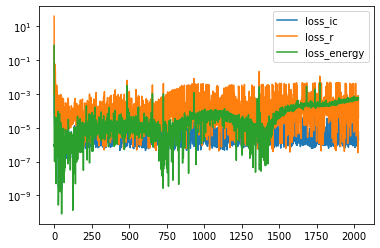

In [30]:
plt.plot(epoch_log, trainer.loss_ics_log, label='loss_ic')
plt.plot(epoch_log, trainer.loss_res_log, label='loss_r')
plt.plot(epoch_log, trainer.loss_energy_log, label='loss_energy')
plt.yscale('log')
plt.legend()
plt.savefig(f'{file}/loss.jpg')

In [ ]:
# load the data
data = scipy.io.loadmat('data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]

In [ ]:
print(t_star.shape)
print(x_star.shape)
usol.shape

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$x$')

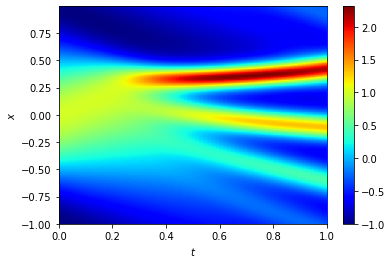

In [33]:
# load the data
data = scipy.io.loadmat('../data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

In [ ]:
# Get trained network parameters
TX = np.hstack((TT.reshape(-1,1), XX.reshape(-1,1)))
TX = torch.from_numpy(TX).double()

model = trainer.model.cpu().double()
u_pred = model(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
print('Relative l2 error: {:.3e}'.format(error))

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarni

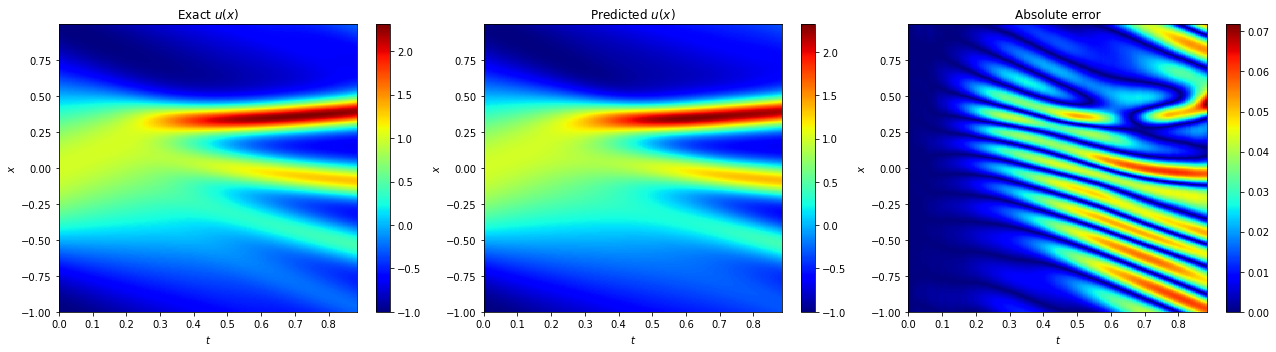

In [34]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT[:, :NT], XX[:, :NT], usol[:, :NT], cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()


plt.subplot(1, 3, 2)
plt.pcolor(TT[:, :NT], XX[:, :NT], pred[:, :NT], cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT[:, :NT], XX[:, :NT], np.abs(usol[:, :NT] - pred[:, :NT]), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.savefig(f'{file}/predict.jpg')

plt.show()

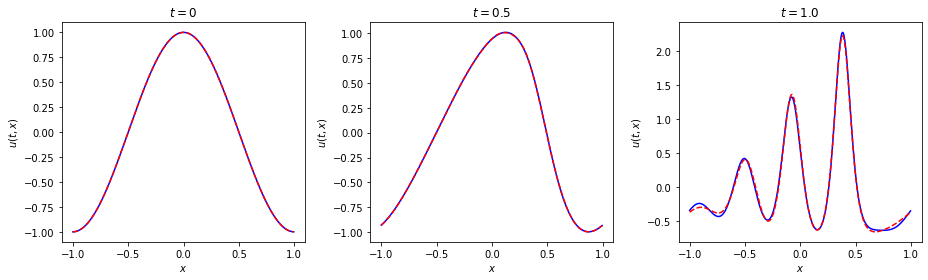

In [35]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue')
plt.plot(x_star, pred[:,0], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,25], color='blue')
plt.plot(x_star, pred[:,25], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,166], color='blue')
plt.plot(x_star, pred[:,166], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.savefig(f'{file}/check_t.jpg')
plt.show()